In [1]:
# Creative AI is a new branch of AI in whch AI can create painting, write compelling stories, and compose new music
#What is DEEP DREAM?
# Deep Dream is the most freaky, creepy AI algorithm to date. 
# It's a computer vision algorithm developed by google. 
# The algorithm works by creating dream like effect.

In [2]:
# Import librairies
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import os
import PIL.Image
import cv2
import random
from PIL import Image # Python Image Library is a library that adds support for opening, manipulating, and saving many different
                      # image file formats

In [3]:
# Load trained inceptionNet model, for more information on Transfer Learning, check previous case studies
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')

In [4]:
#base_model.summary() to see how parameters exist in inceptionNet V3
#Total params: 21,802,784
#Trainable params: 21,768,352
#Non-trainable params: 34,432

# GET AN IMAGE AND PRE-PROCESS IT

In [5]:
# Open the first image
# Source: https://www.pxfuel.com/en/free-photo-xxgfs
img_1 = Image.open("mars.jpg")

# Open the second image
# Source: https://commons.wikimedia.org/wiki/File:Georges_Garen_embrasement_tour_Eiffel.jpg
img_2 = Image.open('eiffel.jpg')

# Blend the two images
image = Image.blend(img_1, img_2, 0.5) # alpha --> The interpolation alpha factor. If alpha is 0.0, a copy of the first image is returned.
# If alpha is 1.0, a copy of the second image is returned. 

# Save the blended image
image.save("img_0.jpg")

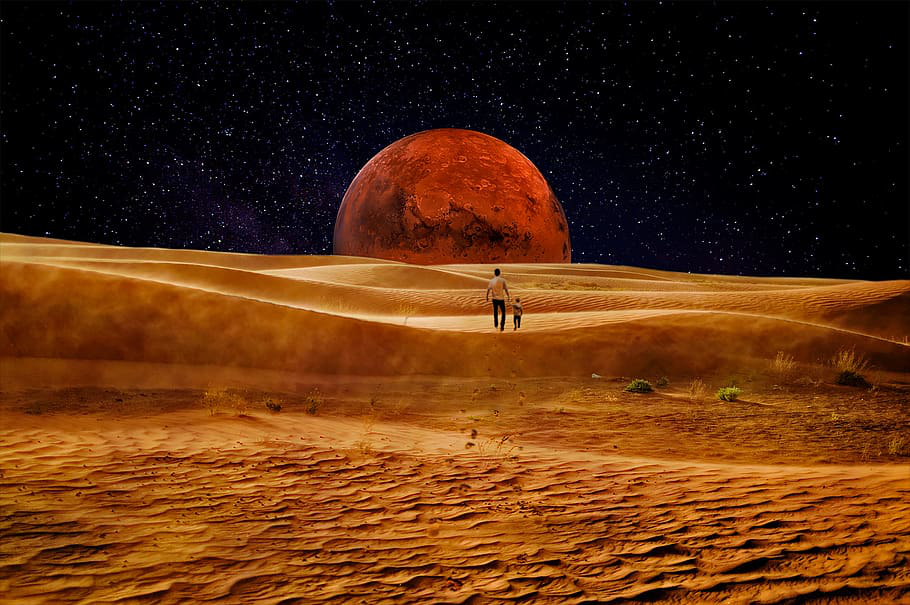

In [6]:
img_1

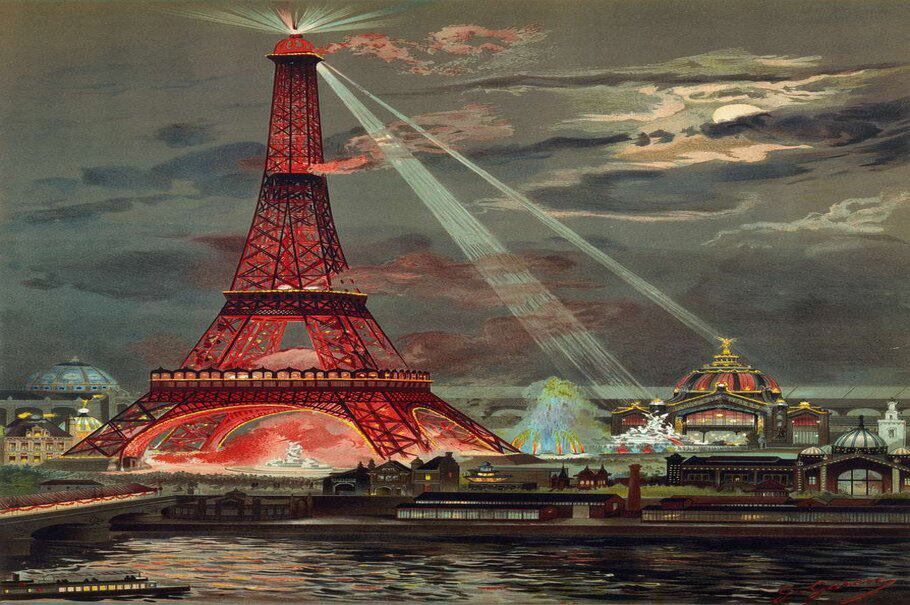

In [7]:
img_2

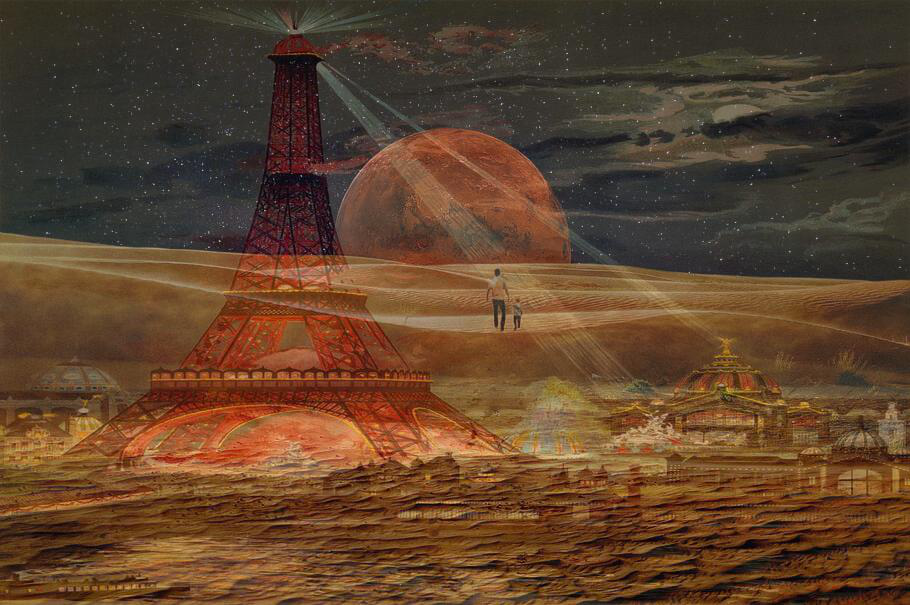

In [8]:
# Load the image
Sample_Image = tf.keras.preprocessing.image.load_img('img_0.jpg')
Sample_Image

In [9]:
# Get the shape of the image
np.shape(Sample_Image)

(605, 910, 3)

In [10]:
# Check out the type of the image
type(Sample_Image)

PIL.JpegImagePlugin.JpegImageFile

In [11]:
# Convert to numpy array
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)

# Sample_Image = np.array(Sample_Image)

In [12]:
# Confirm that the image is converted to Numpy array
type(Sample_Image)

numpy.ndarray

In [13]:
# Obtain the max and min values to see if this image is normalize or not.
# if the max and min value is between 0 and 1 or -1 and 1 the image is normalize, not otherwise
print('min pixel values = {}, max pixel values = {}'.format(Sample_Image.min(), Sample_Image.max()))

min pixel values = 0.0, max pixel values = 255.0


In [14]:
# Normalize the input image. just divide by 255.0
Sample_Image = np.array(Sample_Image)/255.0
Sample_Image.shape

(605, 910, 3)

In [15]:
# Let's verify normalized images values!
print('min pixel values = {}, max pixel values = {}'.format(Sample_Image.min(), Sample_Image.max()))

min pixel values = 0.0, max pixel values = 1.0


In [16]:
# expand dimension to 4D. because most of the time we feed more images at the same time
Sample_Image = tf.expand_dims(Sample_Image, axis = 0)

In [17]:
#Let's verify 4D
np.shape(Sample_Image)

TensorShape([1, 605, 910, 3])

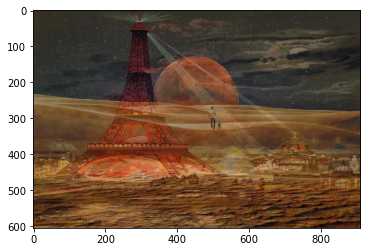

In [18]:
# Mini Challenge
# Perform the opposite of expand dimension of sample_Image
plt.imshow(np.squeeze(Sample_Image))

In [19]:
# let check the reduction dimension
np.squeeze(Sample_Image).shape

(605, 910, 3)

# RUN THE PRETRAINED MODEL AND EXPLORE ACTIVATIONS

In [20]:
#Maximize the activations of these layers

names = ['mixed3', 'mixed5', 'mixed7']

# names = ['mixed3']

layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

In [21]:
#run deepdream_model.summary() to get the parameters below 
#Total params: 8,975,264
#Trainable params: 8,956,448
#Non-trainable params: 18,816

In [25]:
# Let's run the model by feeding in our input image and taking a look at the activations "Neuron outputs"
activations = deepdream_model(Sample_Image)

In [23]:
len(activations)

3

In [29]:
# Deep Dream algorithm steps:
# 1. Forward an image through a trained ANN, CNN, ResNet, etc...
# 2. Select a layer f choice(first layers captures eges, deep layers capture full shapes such as faces).
# 3. Calculate the activations(output) coming out from the layers of interest
# 4. Calculate the gradient of the activations with respect to the input image
# 5. Modify the image to increase these activations, and thus enhance the patterns seen by the network resulting in trippy hallucionated image!
# 6. Iterate and repeat over multiple scales.

In [31]:
# tf.GradientTape() is used to record operations for automatic differentiation
# For example, Let's assume we have the following functions y = x^3.
# The gradient at x = 2 can be computed as follows: dy_dx = 3 * x^2 = 3 * 2^2 = 12.
# Gradient=dy/dx=d(activations/loss)/d(input image)

In [26]:
x = tf.constant(2.0)

In [27]:
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x * x
dy_dx = g.gradient(y, x) # Will compute to 12

In [28]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=12.0>

In [34]:
# MINI CHALLENGE #4:

# Using tf.GradientTape(), calculate the gradient of y = x^4 + x^5 at x = 5
# Verify your answer by manually differentation the equation
x = tf.constant(5.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x * x * x + x * x * x * x * x
dy_dx = g.gradient(y, x)
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=3625.0>

# IMPLEMENT DEEP DREAM ALGORITHM - STEP #1 LOSS CALCULATION

In [41]:
# Since the cal_closs function includes expand dimension, let's squeeze the image (reduce_dims)
Sample_Image.shape

TensorShape([605, 910, 3])

In [43]:
Sample_Image = tf.squeeze(Sample_Image)

In [44]:
Sample_Image.shape

TensorShape([605, 910, 3])

In [45]:
def calc_loss(image, model):
# Function used for loss calculations
# It works by feedforwarding the input image through the network and generate activations
# Then obtain the average and sum of those outputs

  img_batch = tf.expand_dims(image, axis=0) # Convert into batch format
  layer_activations = model(img_batch) # Run the model
  print('ACTIVATION VALUES (LAYER OUTPUT) =\n', layer_activations)
  # print('ACTIVATION SHAPE =\n', np.shape(layer_activations))

  losses = [] # accumulator to hold all the losses
  for act in layer_activations:
    loss = tf.math.reduce_mean(act) # calculate mean of each activation 
    losses.append(loss)
  
  print('LOSSES (FROM MULTIPLE ACTIVATION LAYERS) = ', losses)
  print('LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) = ', np.shape(losses))
  print('SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)= ', tf.reduce_sum(losses))

  return  tf.reduce_sum(losses) # Calculate sum 

In [46]:
loss = calc_loss(tf.Variable(Sample_Image), deepdream_model) # Remember that we created deepdream_model earlier above

ACTIVATION VALUES (LAYER OUTPUT) =
 [<tf.Tensor: shape=(1, 36, 55, 768), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        , ..., 0.02111521,
          0.4271379 , 0.30680236],
         [0.        , 0.1366694 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.25661814, 0.        , ..., 0.        ,
          0.0734762 , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.42646962,
          0.        , 0.        ],
         [0.05945194, 0.        , 0.        , ..., 0.42646962,
          0.64126116, 0.        ]],

        [[0.67513835, 0.        , 0.        , ..., 0.02111521,
          0.2874109 , 0.6544888 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.22241396],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
       

In [47]:
loss # Sum up the losses from both activations

<tf.Tensor: shape=(), dtype=float32, numpy=0.55770755>

# IMPLEMENT DEEP DREAM ALGORITHM - STEP #2 (CALCULATE THE GRADIENT)

In [48]:
# In this step, we will rely on the loss that has been calculated in the previous step and calculate the gradient with respect
# to the given input image and then add it to the input original image.
# Doing so iteratively will result in feeding images that continiously and increasingly excite the neurons and generate more
#dreamy like images!

In [49]:
# When you annotate a function with tf.function, the function can be called like any other python defined function. 
# The benefit is that it will be compiled into a graph so it will be much faster and could be executed over TPU/GPU

@tf.function
def deepdream(model, image, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to `img`
      # `GradientTape` only watches `tf.Variable`s by default
      tape.watch(image)
      loss = calc_loss(image, model) # call the function that calculate the loss 

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    # The syntax is as follows: dy_dx = g.gradient(y, x) 
    gradients = tape.gradient(loss, image)

    print('GRADIENTS =\n', gradients)
    print('GRADIENTS SHAPE =\n', np.shape(gradients))

    # tf.math.reduce_std computes the standard deviation of elements across dimensions of a tensor
    gradients /= tf.math.reduce_std(gradients)  

    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    image = image + gradients * step_size
    image = tf.clip_by_value(image, -1, 1)

    return loss, image

In [50]:
def run_deep_dream_simple(model, image, steps = 100, step_size = 0.01):
  # Convert from uint8 to the range expected by the model.
  image = tf.keras.applications.inception_v3.preprocess_input(image)

  for step in range(steps):
    loss, image = deepdream(model, image, step_size)
    
    if step % 100 == 0:
      plt.figure(figsize=(12,12))
      plt.imshow(deprocess(image))
      plt.show()
      print ("Step {}, loss {}".format(step, loss))

  # clear_output(wait=True)
  plt.figure(figsize=(12,12))
  plt.imshow(deprocess(image))
  plt.show()

  return deprocess(image)

In [51]:
def deprocess(image):
  image = 255*(image + 1.0)/2.0
  return tf.cast(image, tf.uint8)


In [52]:
Sample_Image.shape

TensorShape([605, 910, 3])

ACTIVATION VALUES (LAYER OUTPUT) =
 [<tf.Tensor 'model/mixed3/concat:0' shape=(1, 36, 55, 768) dtype=float32>, <tf.Tensor 'model/mixed5/concat:0' shape=(1, 36, 55, 768) dtype=float32>, <tf.Tensor 'model/mixed7/concat:0' shape=(1, 36, 55, 768) dtype=float32>]
LOSSES (FROM MULTIPLE ACTIVATION LAYERS) =  [<tf.Tensor 'Mean:0' shape=() dtype=float32>, <tf.Tensor 'Mean_1:0' shape=() dtype=float32>, <tf.Tensor 'Mean_2:0' shape=() dtype=float32>]
LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) =  (3,)
SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)=  Tensor("Sum:0", shape=(), dtype=float32)
GRADIENTS =
 Tensor("Reshape_4:0", shape=(605, 910, 3), dtype=float32)
GRADIENTS SHAPE =
 (605, 910, 3)


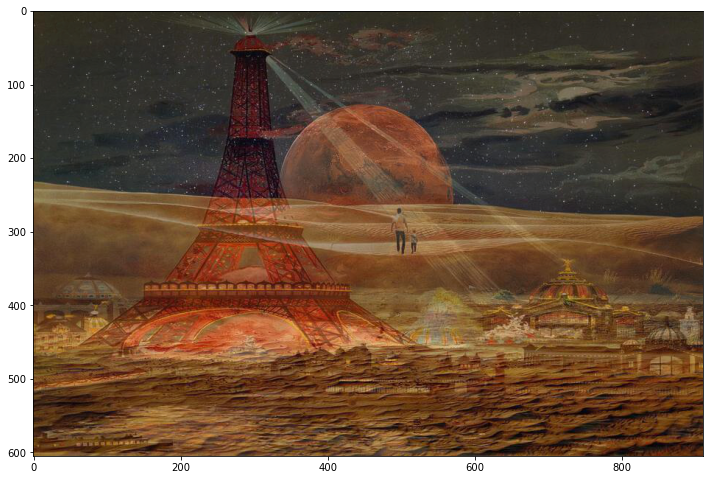

Step 0, loss 0.5804305076599121


In [ ]:
# Let's Load the image again and convert it to Numpy array 
Sample_Image = np.array(tf.keras.preprocessing.image.load_img('img_0.jpg'))
dream_img = run_deep_dream_simple(model = deepdream_model, image = Sample_Image, steps = 4000, step_size = 0.001)


In [ ]:
(VIDEO) APPLY DEEPDREAM TO GENERATE A SERIES OF IMAGES